<a href="https://colab.research.google.com/github/alexx-vrg/NLP_Labs/blob/main/Lab5_Clustering/lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5 - Clustering and Topic Modeling

This notebook explores text clustering and topic modeling using the ArXiv NLP dataset. The pipeline consists of:
1. Embedding documents with sentence-transformers
2. Dimensionality reduction with UMAP
3. Clustering with HDBSCAN
4. Topic modeling with BERTopic

## 1. Load Dataset


In [12]:
import warnings
import os
warnings.filterwarnings("ignore")
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"


In [11]:
%pip install -r requirements.txt -q


In [13]:
from datasets import load_dataset

dataset = load_dataset("maartengr/arxiv_nlp")["train"]
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]
print(f"Loaded {len(abstracts)} documents")


Loaded 44949 documents


## 2. Create Embeddings

Using `thenlper/gte-small` - a compact but effective embedding model optimized for semantic similarity.


In [14]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer('thenlper/gte-small')
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)
print(f"Embeddings shape: {embeddings.shape}")


Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

Embeddings shape: (44949, 384)


## 3. Dimensionality Reduction with UMAP

Reducing from 384 dimensions to 5 to enable effective clustering. UMAP preserves both local and global structure.


In [15]:
from umap import UMAP

umap_model = UMAP(n_components=5, min_dist=0.0, metric='cosine', random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)


## 4. Clustering with HDBSCAN

HDBSCAN automatically determines cluster count and handles outliers (labeled as -1).


In [16]:
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(min_cluster_size=50, metric='euclidean', cluster_selection_method='eom')
hdbscan_model.fit(reduced_embeddings)
clusters = hdbscan_model.labels_
print(f"Number of clusters: {len(set(clusters))}")


Number of clusters: 155


In [17]:
import numpy as np

# Inspect first 3 documents in cluster 0
cluster = 0
print(f"Sample documents from cluster {cluster}:\n")
for index in np.where(clusters==cluster)[0][:3]:
    print(list(abstracts)[index][:200] + "...\n")


Sample documents from cluster 0:

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesiz...

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focu...

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation syste...



## 5. Cluster Visualization

Reducing to 2D for visualization. Outliers shown in grey.


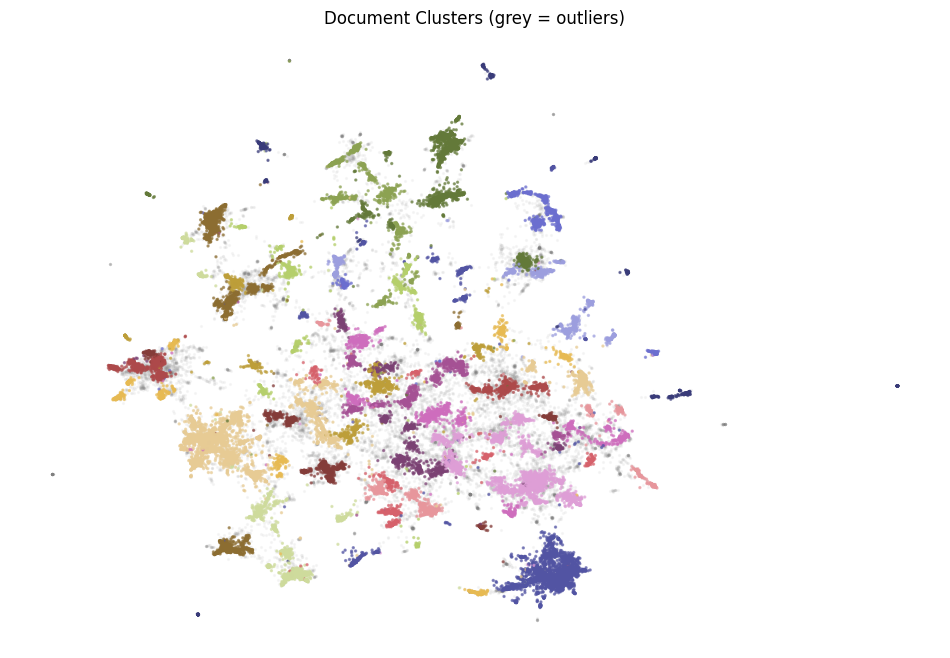

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Reduce to 2D for visualization
reduced_2d = UMAP(n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

df = pd.DataFrame(reduced_2d, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

clusters_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :]

plt.figure(figsize=(12, 8))
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey")
plt.scatter(clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int), alpha=0.6, s=2, cmap='tab20b')
plt.axis('off')
plt.title("Document Clusters (grey = outliers)")
plt.show()


## 6. Topic Modeling with BERTopic

BERTopic extracts keywords for each cluster using c-TF-IDF, creating interpretable topic descriptions.


In [19]:
from bertopic import BERTopic

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts, embeddings)


2025-12-14 14:06:18,784 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-14 14:07:14,059 - BERTopic - Dimensionality - Completed ✓
2025-12-14 14:07:14,061 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-14 14:07:16,027 - BERTopic - Cluster - Completed ✓
2025-12-14 14:07:16,041 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-14 14:07:19,705 - BERTopic - Representation - Completed ✓


In [20]:
topic_model.get_topic_info().head(10)


,Topic,Count,Name,Representation,Representative_Docs
0,-1,14210,-1_of_the_and_to,"[of, the, and, to, in, we, language, for, that...",[ GPT-$3$ has attracted lots of attention due...
1,0,2316,0_speech_asr_recognition_end,"[speech, asr, recognition, end, acoustic, spea...",[ The speech chain mechanism integrates autom...
2,1,2183,1_question_qa_questions_answer,"[question, qa, questions, answer, answering, a...",[ Text-based Question Generation (QG) aims at...
3,2,941,2_translation_nmt_machine_bleu,"[translation, nmt, machine, bleu, neural, engl...","[ Recently, the development of neural machine..."
4,3,880,3_summarization_summaries_summary_abstractive,"[summarization, summaries, summary, abstractiv...",[ Sentence summarization shortens given texts...
5,4,853,4_hate_offensive_speech_detection,"[hate, offensive, speech, detection, toxic, so...",[ Current research on hate speech analysis is...
6,5,684,5_gender_bias_biases_debiasing,"[gender, bias, biases, debiasing, fairness, st...",[ Gender-bias stereotypes have recently raise...
7,6,630,6_relation_extraction_re_relations,"[relation, extraction, re, relations, entity, ...",[ Knowledge base provides a potential way to ...
8,7,591,7_ner_entity_named_recognition,"[ner, entity, named, recognition, entities, ne...",[ Named entity recognition (NER) models gener...
9,8,448,8_agents_agent_game_games,"[agents, agent, game, games, communication, pl...",[ A wide range of real-world applications is ...


In [21]:
# Get top keywords for topic 0
topic_model.get_topic(0)


[('speech', np.float64(0.028208883288593535)),
 ('asr', np.float64(0.018842312810416793)),
 ('recognition', np.float64(0.01351959051292077)),
 ('end', np.float64(0.009745990895354896)),
 ('acoustic', np.float64(0.009384710004108402)),
 ('speaker', np.float64(0.006877359138616964)),
 ('audio', np.float64(0.006785262733110495)),
 ('the', np.float64(0.006370412745274845)),
 ('error', np.float64(0.00634287314665723)),
 ('automatic', np.float64(0.0063065026437668335))]

## 7. Representation Models

Improving topic representations with KeyBERT and MMR for more coherent keywords.


In [22]:
from copy import deepcopy
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance

original_topics = deepcopy(topic_model.topic_representations_)

# Update with KeyBERTInspired
representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model=representation_model)

# Compare original vs updated for topic 0
print("Original:", [w for w, _ in original_topics[0][:5]])
print("KeyBERT:", [w for w, _ in topic_model.get_topic(0)[:5]])


Original: ['speech', 'asr', 'recognition', 'end', 'acoustic']
KeyBERT: ['phonetic', 'encoder', 'transcription', 'speech', 'language']


## 8. Activity: Topic Labels with Groq API

Implementing `update_topics_with_groq` function to generate human-readable topic labels using an LLM.


In [23]:
from groq import Groq
from dotenv import load_dotenv
import time
import random

load_dotenv()

def update_topics_with_groq(topic_model, documents, model="meta-llama/llama-4-scout-17b-16e-instruct"):
    client = Groq()
    topics = topic_model.get_topics()
    updated_labels = {}

    prompt_template = """I have a topic that contains the following documents:
{documents}

The topic is described by the following keywords: '{keywords}'.

Based on the documents and keywords, what is this topic about?
Respond with only: topic: <short topic label>"""

    for topic_id in topics:
        if topic_id == -1:
            continue

        rep_docs = topic_model.get_representative_docs(topic_id)[:5]
        docs_text = "\n".join(rep_docs)
        keywords = ", ".join([w for w, _ in topics[topic_id][:10]])

        prompt = prompt_template.format(documents=docs_text, keywords=keywords)

        for attempt in range(3):
            try:
                response = client.chat.completions.create(
                    model=model,
                    messages=[
                        {"role": "system", "content": "You are a helpful assistant that creates concise topic labels."},
                        {"role": "user", "content": prompt}
                    ],
                    temperature=0,
                    max_tokens=500
                )
                label = response.choices[0].message.content.strip()
                if label.lower().startswith("topic:"):
                    label = label[6:].strip()
                updated_labels[topic_id] = label
                time.sleep(random.uniform(0.5, 1.0))
                break
            except Exception as e:
                print(f"Retry {attempt+1} for topic {topic_id}: {e}")
                time.sleep(2 ** attempt)
        else:
            updated_labels[topic_id] = f"Topic {topic_id}"

    topic_model.set_topic_labels(updated_labels)
    return topic_model

# Run the function (uncomment when API key is set)
# topic_model = update_topics_with_groq(topic_model, abstracts)
# topic_model.get_topic_info().head(10)


## 9. Word Cloud Visualization


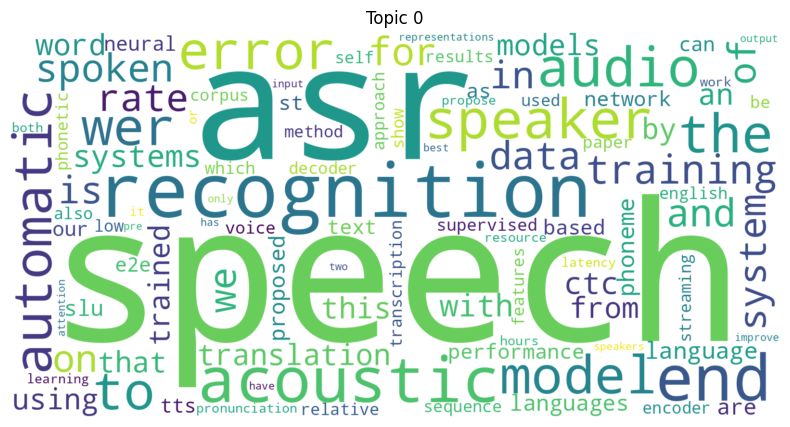

In [24]:
from wordcloud import WordCloud

topic_model.update_topics(abstracts, top_n_words=100)

def create_wordcloud(model, topic):
    plt.figure(figsize=(10, 5))
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=100, width=1600, height=800)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {topic}")
    plt.show()

create_wordcloud(topic_model, topic=0)
